In [10]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    


In [14]:
import h5py
import torch

def getDataAsTensors(filepath, numpy=False):
    with h5py.File(filepath, "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print(f"Keys: {f.keys()}")
        print(len(f["image"]))
        imgs = f["image"][:]
        signals = f["signal"][:]
    if numpy:
        return imgs, signals
    t = torch.from_numpy(imgs)
    s = torch.from_numpy(signals)

    # Print overall max and min pixel values
    print(f"Overall Max Pixel Value: {t.max()}")
    print(f"Overall Min Pixel Value: {t.min()}")

    print("imgs:", t.size(), ", signals: ",s.size())
    return t, s, t.max()



In [15]:
### Datasets ###
#jets - 8 726 datapoints (formerly jet-images_micro)
#jet-images_train - 628 320 datapoints
#jet-images_val - 157 080 datapoints
#jet-images_test - 87 266 datapoints
micro_path = "jet-data/jets.hdf5"
test_path = "jet-data/jet-images_test.hdf5"
val_path = "jet-data/jet-images_val.hdf5"
train_path = "jet-data/jet-images_train.hdf5"

In [16]:
imgs, labels, max_val = getDataAsTensors(micro_path)
train_size = int(0.8 * len(imgs))
test_size = len(imgs) - train_size
train_dataset, test_dataset = random_split(CustomDataset(imgs, labels), [train_size, test_size])
#print(train_dataset[1])
print(len(train_dataset))

Keys: <KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
8726
Overall Max Pixel Value: 279.44305419921875
Overall Min Pixel Value: 0.0
imgs: torch.Size([8726, 25, 25]) , signals:  torch.Size([8726])
6980


In [17]:

batch_size = 256


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ('general', 'W-boson')

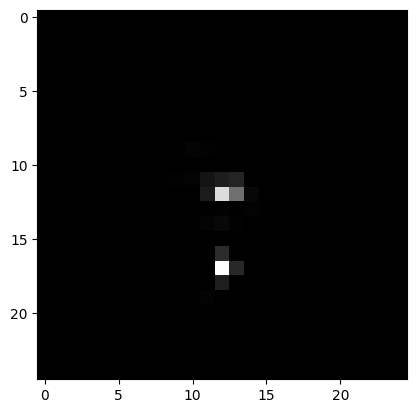

W-boson W-boson general W-boson W-boson W-boson W-boson W-boson general general W-boson general general W-boson W-boson general general general general W-boson W-boson general W-boson general general W-boson general W-boson general W-boson W-boson general general general general W-boson general W-boson W-boson W-boson general general W-boson W-boson W-boson general general general general W-boson general W-boson general W-boson W-boson W-boson general general general W-boson W-boson W-boson general W-boson general W-boson W-boson general general W-boson W-boson general general W-boson general general W-boson W-boson general general general W-boson W-boson general general W-boson general W-boson W-boson W-boson general general general general general general general W-boson general general W-boson general general W-boson general W-boson W-boson W-boson general general W-boson general W-boson W-boson general W-boson W-boson W-boson W-boson general general W-boson W-boson W-boson W-boson 

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')  # Display the first channel of the image grid and use grayscale colormap
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images
imshow(images[0])
# Print labels
print(' '.join(f'{classes[int(labels[j].item())]:5s}' for j in range(batch_size)))



In [19]:
import torch.nn as nn
import torch.nn.functional as F
#from src.utils.model import GlobalAvgPool

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 channel as input
        self.dropout1 = nn.Dropout(p=0.1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout3 = nn.Dropout(p=0.1)
        
        # Adjusted for 25x25 input images:
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.dropout4 = nn.Dropout(p=0.1)        
        self.fc2 = nn.Linear(120, 84)
        self.dropout5 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1) 
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.dropout4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
def train(model):
    for epoch in range(10): 
        running_loss = 0.0
        print("epoch ", epoch, " done")
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            labels = labels.float().unsqueeze(1)


            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')

In [22]:
train(net)

epoch  0  done
epoch  1  done
epoch  2  done
epoch  3  done
epoch  4  done
epoch  5  done
epoch  6  done
epoch  7  done
epoch  8  done
epoch  9  done
Finished Training


In [23]:
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

In [24]:
# Put the model in evaluation mode
print("Training: ", net.training)
net.eval()
print("Training: ", net.training)

correct = 0
total = 0
_preds = np.empty((0,1))
_preds_01 = np.empty((0,1))
_labels = np.empty((0,1))


with torch.no_grad():
    for data in testloader: 
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        labels = labels.float().unsqueeze(1)

        
        outputs = net(inputs)
        
        # Treat the output as a probability using the sigmoid function
        probabilities = torch.sigmoid(outputs)
        _preds = np.append(_preds, probabilities)
        _labels = np.append(_labels, labels)
        

        # Threshold the probabilities to get predicted labels (0 or 1)
        predicted = (probabilities > 0.5).float()
        _preds_01 = np.append(_preds_01, predicted)
        
        print(probabilities.data[1])

        total += labels.size(0)
        # Ensure labels are in the same shape (batch_size, 1) as predicted
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print(_preds.shape, _preds[0])


Training:  True
Training:  False
tensor([0.6753])
tensor([0.8148])
tensor([0.2523])
tensor([0.5799])
tensor([0.3042])
tensor([0.3472])
tensor([0.1774])
Accuracy of the network on the test images: 73 %
(1746,) 0.6922193169593811


In [25]:
import sys

import numpy as np

import torch
import torch.nn as nn

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

#Verb prints out the same index of output for every pass.          
def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples, _verb=False):

    dropout_predictions = np.empty((0, n_samples))

    sigmoid = nn.Sigmoid()

    for fp in range(forward_passes):
        predictions = np.empty((0,))
        model.train()
        enable_dropout(model)
        verb = _verb

        for _, (image, label) in enumerate(data_loader):
            image = image.unsqueeze(1)
            label = label.float().unsqueeze(1)
            if verb:
                print("image shape", image.shape, ", fp_n=",fp)
                print("Training: ", model.training)
            with torch.no_grad():
                output = model(image)
                output = sigmoid(output).squeeze(1)  # shape (n_samples,)
                if verb:
                    print("output shape", output.shape, output[2])
            
            predictions = np.append(predictions, output.cpu().numpy())
            verb = False

        dropout_predictions = np.vstack((dropout_predictions, predictions))        
        # dropout predictions - shape (forward_passes, n_samples)

    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples,)

    # Calculating standard deviation across multiple MCD forward passes 
    std = np.std(dropout_predictions, axis=0)  # shape (n_samples,)

    epsilon = sys.float_info.min

    # Calculating entropy for binary classification
    entropy = -(mean * np.log(mean + epsilon) + (1 - mean) * np.log(1 - mean + epsilon))  # shape (n_samples,)

    # Calculating mutual information for binary classification
    expected_entropy = -np.mean(dropout_predictions * np.log(dropout_predictions + epsilon) +
                                (1 - dropout_predictions) * np.log(1 - dropout_predictions + epsilon), axis=0)
    mutual_info = entropy - expected_entropy  # shape (n_samples,)

    return mean, std, mutual_info, dropout_predictions

In [26]:
mean,std, mutual_info, dropout_predictions = get_monte_carlo_predictions(data_loader=testloader,
                                forward_passes=100,
                                model=net,
                                n_classes=1,
                                n_samples=test_size,)
#image shape torch.Size([256, 1, 25, 25]) , fp_n= 1

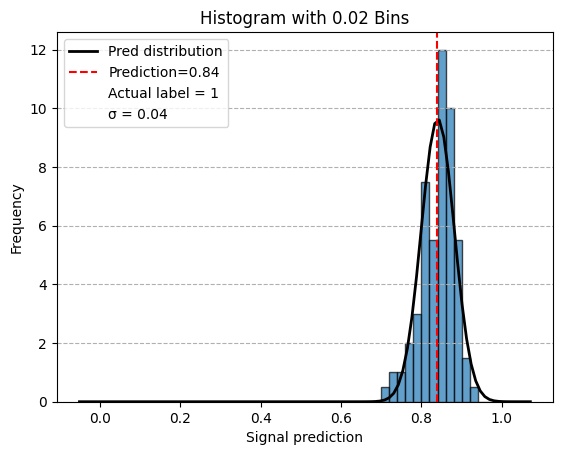

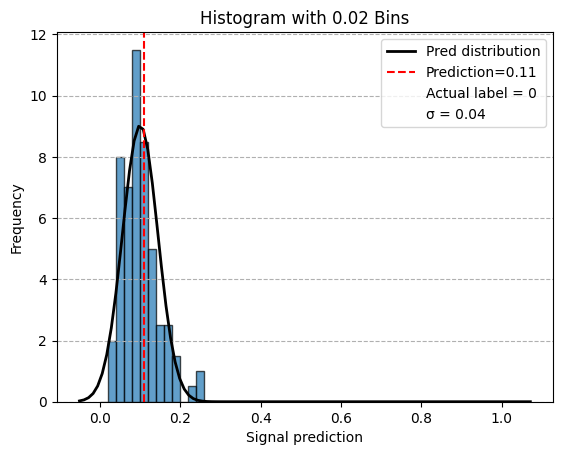

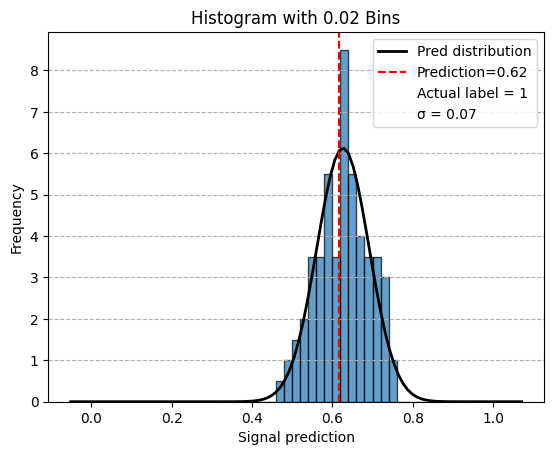

In [63]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_histogram(values, label, threshold=0.02, original_predicition=None, std=None, ):
       # Ensure all values are between 0 and 1
    filtered_values = [v for v in values if 0 <= v <= 1]

    # Set the bin edges based on the given threshold
    bins = [i*threshold for i in range(int(1/threshold) + 2)]  # +2 to include the upper bound

    # Calculate the histogram data without plotting
    y, x, _ = plt.hist(filtered_values, bins=bins, edgecolor='black', alpha=0.7, density=True)
    plt.xlabel(f'Signal prediction')
    plt.ylabel('Frequency')
    plt.title(f'Histogram with {threshold} Bins')
    plt.grid(axis='y', linestyle='--')
    
    # Plot Gaussian distribution
    mean = np.mean(filtered_values)
    std = np.std(filtered_values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2, label="Pred distribution")
    plt.legend()
    if original_predicition is not None:
        plt.axvline(x=original_predicition, color='red', linestyle='--', label=f'Prediction={original_predicition:.2f}')
        plt.legend()
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    current_labels.append(f'Actual label = {label:.0f}')
    current_handles.append(plt.Rectangle((0, 0), 0, 0, fc="white", fill=False, edgecolor='none', linewidth=0))
    current_labels.append(f'σ = {std:.2f}')
    current_handles.append(plt.Rectangle((0, 0), 0, 0, fc="white", fill=False, edgecolor='none', linewidth=0))
    plt.legend(handles=current_handles, labels=current_labels)
    plt.show()

# Example
indexToInspect = 7
values = dropout_predictions[:, indexToInspect]
plot_histogram(values, original_predicition=_preds[indexToInspect], std=std[indexToInspect], label=_labels[indexToInspect])
indexToInspect = 770
values = dropout_predictions[:, indexToInspect]
plot_histogram(values, original_predicition=_preds[indexToInspect], std=std[indexToInspect], label=_labels[indexToInspect])
indexToInspect= 913
values = dropout_predictions[:, indexToInspect]
plot_histogram(values, original_predicition=_preds[indexToInspect], std=std[indexToInspect], label=_labels[indexToInspect])

In [28]:
def find_matching_indices(list2, list1):
    """Find indices where value in list1 is <0.05 and value in list2 is between 0.4 and 0.5."""
    matching_indices = []
    
    # Iterate over both lists simultaneously
    for idx, (val1, val2) in enumerate(zip(list1, list2)):
        if val1 < 0.04 and 0.41 <= val2 <= 0.45:
            matching_indices.append(idx)
            
    return matching_indices
print(find_matching_indices(_preds, std))  # This should print [0, 2]

[323]


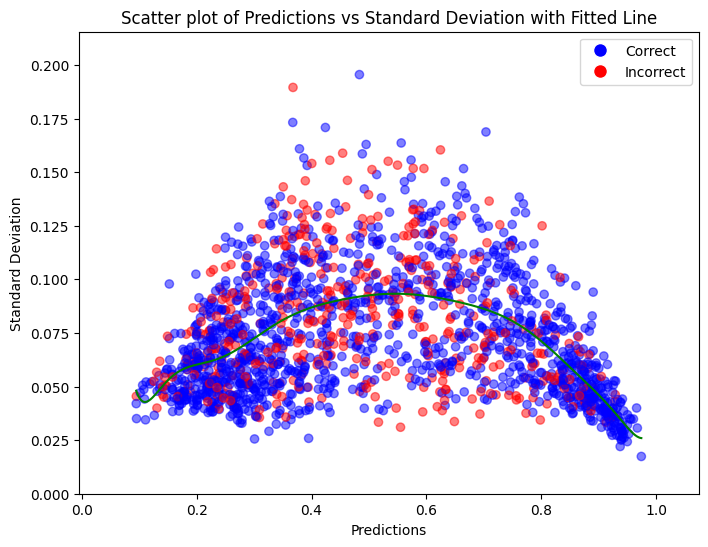

In [29]:
def scatter_plot(preds, std, labels, degree=2):
    if len(preds) != len(std) or len(preds) != len(labels):
        print("All lists should have the same length!")
        return
    
    # Create a list of colors based on the correctness of predictions
    colors = ['blue' if ((p > 0.5 and l == 1) or (p <= 0.5 and l == 0)) else 'red' for p, l in zip(preds, labels)]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(preds, std, color=colors, alpha=0.5)
    
    # Fit a line to the data
    coefficients = np.polyfit(preds, std, degree)
    polynomial = np.poly1d(coefficients)
    
    # Generate y-values based on the fitted polynomial
    xs = np.linspace(min(preds), max(preds), 500)
    fitted_y = polynomial(xs)
    
    # Plot the fitted polynomial
    plt.plot(xs, fitted_y, color='green', label=f'Fitted Polynomial (Degree {degree})')
    
    # Create a custom legend
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Correct', markersize=10, markerfacecolor='blue')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markersize=10, markerfacecolor='red')
    plt.legend(handles=[blue_patch, red_patch])
    
    plt.xlabel("Predictions")
    plt.ylabel("Standard Deviation")
    plt.title("Scatter plot of Predictions vs Standard Deviation with Fitted Line")
    plt.xlim([min(preds)-0.1, max(preds)+0.1])  # assuming predictions are between 0 and 1
    plt.ylim([0, max(std)+0.02])
    plt.show()
    
scatter_plot(_preds, std, _labels, 12)  # Make sure you also provide the 'labels' list when calling the function

(1746,) torch.Size([210, 1])


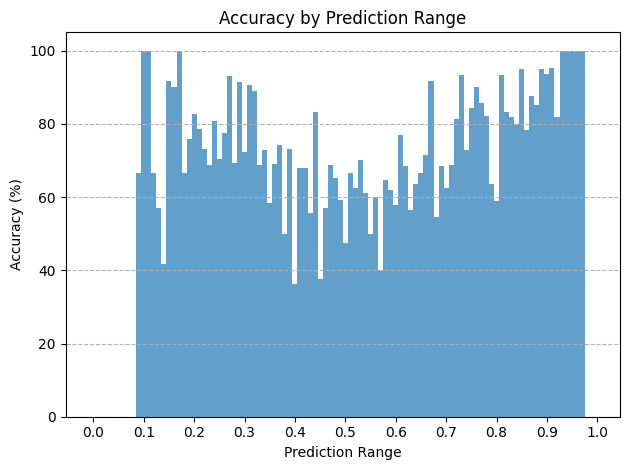

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_histogram(predictions, labels, bin_size=0.05):
    if len(predictions) != len(labels):
        print("Predictions and labels must have the same length!")
        return
    
    # Grouping the predictions in bins
    bins = np.arange(0, 1 + bin_size, bin_size)
    bin_indices = np.digitize(predictions, bins) - 1
    
    correct_counts = np.zeros_like(bins[:-1])
    total_counts = np.zeros_like(bins[:-1])
    
    for pred, label in zip(predictions, labels):
        bin_index = min(int(pred / bin_size), len(bins) - 2)  # Ensure it's within range
        if (pred > 0.5 and label == 1) or (pred <= 0.5 and label == 0):
            correct_counts[bin_index] += 1
        total_counts[bin_index] += 1
    
    # Calculating accuracy for each bin
    accuracies = np.divide(correct_counts, total_counts, out=np.zeros_like(correct_counts), where=total_counts!=0) * 100
    
    # Plotting the histogram
    plt.bar(bins[:-1], accuracies, width=bin_size, alpha=0.7)
    plt.xlabel('Prediction Range')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Prediction Range')
    plt.ylim(0, 105)  # To make the y-axis range from 0 to 105 for clarity
    plt.grid(axis='y', linestyle='--')

    # Set x-ticks every 0.1 and remove bin labels
    plt.xticks(np.arange(0, 1.1, 0.1))

    plt.tight_layout()
    plt.show()

# Sample usage (assuming _preds and _labels are defined somewhere in your code):
# print(_preds.shape, labels.shape)
# plot_accuracy_histogram(_preds, _labels, bin_size=0.005)



print(_preds.shape, labels.shape)
plot_accuracy_histogram(_preds, _labels, bin_size=0.01)


In [79]:
def gaussian_noise(img, mean=0.2, std=4):
    """Apply Gaussian noise to the image batch"""
    noisy_img = img.clone().detach()

    # Generate Gaussian noise for each image in the batch
    noise = torch.normal(mean, std, size=img.shape)

    # Add noise
    noisy_img += noise

    # Clip values to be between 0 and 275
    torch.clamp(noisy_img, 0, 275, out=noisy_img)

    return noisy_img


def get_gaussian_predictions(data_loader, forward_passes, model, n_classes, n_samples, _verb=False, mean=0, std=4):
    predictions_storage = np.empty((0, n_samples))
    sigmoid = nn.Sigmoid()

    for fp in range(forward_passes):
        predictions = np.empty((0,))
        model.eval()  # Ensure model is in eval mode
        verb = _verb

        for _, (image, label) in enumerate(data_loader):
            image = image.unsqueeze(1)
            label = label.float().unsqueeze(1)

            noisy_image = gaussian_noise(image, mean, std)
            label = label.float().unsqueeze(1)

            if verb:
                print("image shape", noisy_image.shape, ", fp_n=",fp)
            with torch.no_grad():
                output = model(noisy_image)
                output = sigmoid(output).squeeze(1)
                if verb:
                    print("output shape", output.shape, output[2])

            predictions = np.append(predictions, output.cpu().numpy())
            verb = False

        predictions_storage = np.vstack((predictions_storage, predictions))

    mean_val = np.mean(predictions_storage, axis=0)
    std_val = np.std(predictions_storage, axis=0)
    epsilon = sys.float_info.min

    entropy = -(mean_val * np.log(mean_val + epsilon) + (1 - mean_val) * np.log(1 - mean_val + epsilon))
    expected_entropy = -np.mean(predictions_storage * np.log(predictions_storage + epsilon) +
                                (1 - predictions_storage) * np.log(1 - predictions_storage + epsilon), axis=0)
    mutual_info = entropy - expected_entropy

    return mean_val, std_val, mutual_info, predictions_storage


In [86]:
gauss_mean, gauss_std, gauss_mutual_info, gauss_predictions = get_gaussian_predictions(data_loader=testloader,
                                forward_passes=100,
                                model=net,
                                n_classes=1,
                                n_samples=test_size, std=7)

In [87]:
print(gauss_predictions[:, 7])
max(gauss_std)

[0.75328904 0.78980762 0.83280671 0.77245992 0.75344181 0.73777449
 0.73303312 0.76895988 0.78720468 0.74581105 0.75062257 0.82799619
 0.73650306 0.82056773 0.73601699 0.77116156 0.74331468 0.79804003
 0.77323985 0.78474927 0.74006653 0.67886782 0.72242832 0.75234246
 0.71359318 0.62983286 0.77567738 0.72771531 0.75961137 0.69972581
 0.72977304 0.78731936 0.803904   0.76213628 0.79312509 0.80389315
 0.54320616 0.71646768 0.81600046 0.73845011 0.75570619 0.76010263
 0.77825916 0.73987681 0.70385903 0.74366593 0.7690118  0.78293979
 0.70060062 0.76155233 0.74907196 0.76344258 0.76111519 0.72505778
 0.78490418 0.76501542 0.73403692 0.76784611 0.79659671 0.77588874
 0.76998514 0.72562927 0.79920596 0.69970405 0.81819928 0.69058567
 0.76113802 0.79042053 0.68413562 0.76694542 0.74563682 0.74212849
 0.75777608 0.7717644  0.79300946 0.80686057 0.77018225 0.732225
 0.71391481 0.70146841 0.78825927 0.79455739 0.65665865 0.76300657
 0.79608607 0.74326307 0.73150402 0.75542527 0.81442386 0.767017

0.1196282085490848

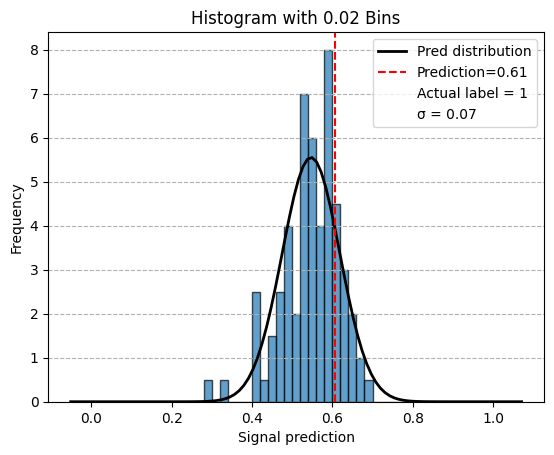

In [88]:
indexToInspect = 700
values = gauss_predictions[:, indexToInspect]
plot_histogram(values, original_predicition=_preds[indexToInspect], std=gauss_std[indexToInspect], label=_labels[indexToInspect])

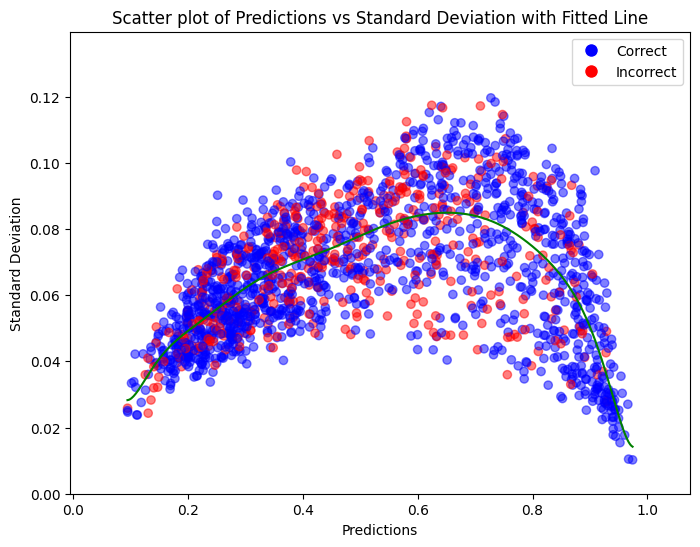

Mean Absolute Error (MAE): 0.01


In [89]:
from sklearn.metrics import mean_absolute_error
scatter_plot(_preds, gauss_std, _labels, 12)  # Make sure you also provide the 'labels' list when calling the function
mae = mean_absolute_error(std, gauss_std)
print(f"Mean Absolute Error (MAE): {mae:.2f}")